In [34]:
import h5py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
with h5py.File("../aeff_input_tracks/effective_area.h5", 'r') as f:
            area10 = f['2010/nu_mu/area'][()]
            lE_bin_edges = f['2010/nu_mu/bin_edges_0'][:] # True Energy [GeV]
            cosz_bin_edges = f['2010/nu_mu/bin_edges_1'][:] # cos(zenith)
            rE_bin_edges = f['2010/nu_mu/bin_edges_2'][:] # Reco Energy [GeV]

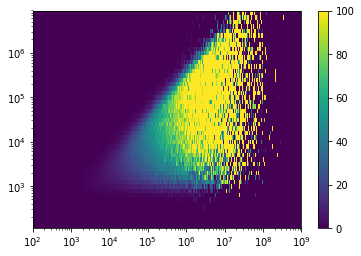

In [242]:
tE_binc = 0.5*(lE_bin_edges[:-1]+lE_bin_edges[1:])
rE_binc = 0.5*(rE_bin_edges[:-1]+rE_bin_edges[1:])

plt.pcolormesh(tE_binc, rE_binc, area10.sum(axis=1).T, vmax=100)
plt.loglog()
plt.colorbar()


In [250]:
print(area10.shape)
print(rE_binc.shape)

(280, 11, 50)
(50,)


In [205]:
class chi2fit:
    def __init__(self, data, model):
        self.data_x, self.data_y = data
        self.model = model
        
    def __call__(self, params):
       
        expec = self.model(self.data_x, params)
        mask = expec!=0
        chi2 =  ((expec-self.data_y)**2/expec)[mask]
        chi2mask = np.isfinite(chi2)
    
        return chi2[chi2mask].sum()

    
model = lambda x, pars: stats.lognorm.pdf(x, scale=pars[0], s=pars[1]**2)

  

In [248]:
area10.sum(axis=1).shape

(280, 50)

In [361]:
logrEbins = np.log10(rE_binc)
print(logrEbins.shape)

fit_params = []
for index in range(len(tE_binc)):
    #index = 210
    e_reso = area10.sum(axis=1)[index]
    e_reso = e_reso/e_reso.sum() / (logrEbins[1]-logrEbins[0])

    fit = chi2fit((logrEbins, e_reso), model)
    seed_mu = np.average(logrEbins, weights=e_reso)
   
    if ~np.isfinite(seed):
        seed_mu = 3
        
    
    res = scipy.optimize.fmin_l_bfgs_b(lambda x, *pars: fit(x, *pars), [seed, 0.5], approx_grad=True,  bounds=((np.max([0, seed_mu-1]), seed_mu+1), (0.1, None)), factr=100)
    fit_params.append(res[0])

"""    
plt.semilogy()


plt.plot(logrEbins, e_reso)

plt.plot(xs, scipy.stats.lognorm.pdf(xs, scale=res[0][0], s=res[0][1]**2))

plt.ylim(1E-4, 10)
plt.semilogy()
"""

(50,)


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


'    \nplt.semilogy()\n\n\nplt.plot(logrEbins, e_reso)\n\nplt.plot(xs, scipy.stats.lognorm.pdf(xs, scale=res[0][0], s=res[0][1]**2))\n\nplt.ylim(1E-4, 10)\nplt.semilogy()\n'

In [362]:
fit_params = np.asarray(fit_params)

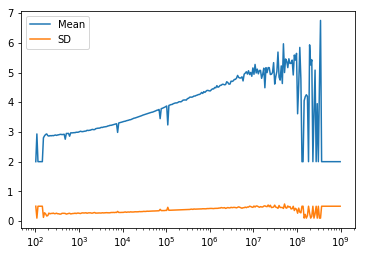

In [363]:
plt.plot(tE_binc, fit_params[:, 0], label="Mean")
plt.plot(tE_binc, fit_params[:, 1], label="SD")
plt.semilogx()
plt.legend()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


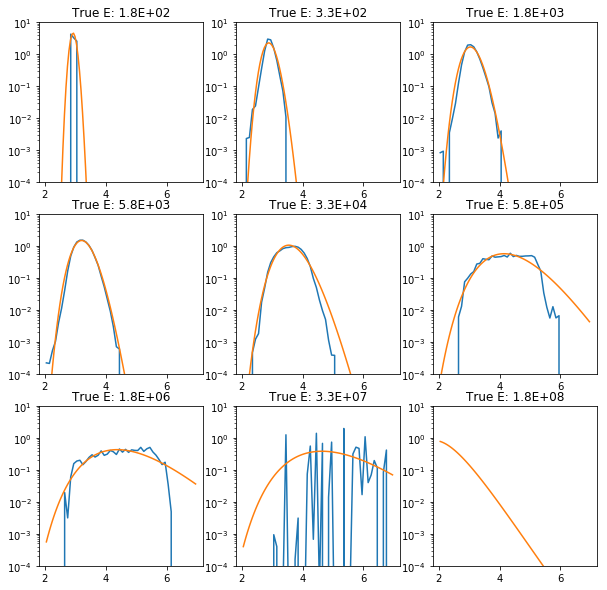

In [364]:
plot_indices = [10, 20, 50, 70, 100, 150, 170, 220, 250]

fig, axs = plt.subplots(3, 3, figsize=(10, 10))

fl_ax = axs.ravel()
for i, pi in enumerate(plot_indices):
    e_reso = area10.sum(axis=1)[pi]
    e_reso = e_reso/e_reso.sum() / (logrEbins[1]-logrEbins[0])
    fl_ax[i].plot(logrEbins, e_reso)
    res = fit_params[pi, :]

    fl_ax[i].plot(xs, scipy.stats.lognorm.pdf(xs, scale=res[0], s=res[1]**2))
    
    fl_ax[i].set_ylim(1E-4, 10)
    fl_ax[i].set_yscale("log")
    fl_ax[i].set_title("True E: {:.1E}".format(tE_binc[pi]))



In [348]:
f = h5py.File("../aeff_input_tracks/effective_area.h5", 'r')


In [14]:
f["2010/nu_mu/area"][:]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.